## Initial imports

In [1]:
import os
import warnings
import random
os.environ["KERAS_BACKEND"] = "tensorflow"
warnings.filterwarnings('ignore')
random.seed(17)

import math
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras import Sequential

## Data Read

In [2]:
model = None
model_weight_filename = 'stocks-lstm.weights.h5'
with open("model_config.json", "r") as json_file:
    model = Sequential.from_config(json.load(json_file))
    model.load_weights(model_weight_filename)

model

<Sequential name=sequential, built=True>

In [3]:
directory_path = "../data/stocks/testing"
contents = sorted([filename.replace(".csv", "") for filename in os.listdir(directory_path)])
random.shuffle(contents)

def read_data_for_symbol(symbol):
    training_data = pd.read_csv(
        os.path.join(directory_path, f"{symbol}.csv"),
        index_col=0
    )
    training_data['Date'] = pd.to_datetime(training_data['Date'])
    training_data = training_data.reset_index(drop=True)

    return training_data

def scale_values_and_make_scaler(data_to_scale):
    scaled_data = data_to_scale.copy(deep=True)

    Close_Scaler = MinMaxScaler()
    scaled_data[['Close_Scaled']] = Close_Scaler.fit_transform(scaled_data[['Close']].to_numpy())

    return scaled_data, Close_Scaler

# symbols_to_check = random.choices(contents, k=5)
symbols_to_check = ['AAPL']
print(symbols_to_check)


['AAPL']


In [4]:
# Function to create sequences (for single column data)
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

def get_X_y_for_data(data_to_use):
    seq_length = 60  
    X, y = create_sequences(data_to_use[["Close_Scaled"]].to_numpy(), seq_length)

    X = X.reshape((X.shape[0], X.shape[1], 1))

    return X, y


        Date       Close        High         Low        Open    Volume
0 2025-01-02  242.752106  247.978468  240.731247  247.809220  55740700
1 2025-01-03  242.264297  243.080598  240.800915  242.264297  40244100
2 2025-01-06  243.896912  246.216423  242.105013  243.210016  45045600
3 2025-01-07  241.119492  244.444450  240.263363  241.886014  40856000
4 2025-01-08  241.607254  242.612716  238.969192  240.830767  37628900
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Root Mean Squared Error for AAPL 7.113429542544489
['2025-11-04T00:00:00.000000000' '2025-11-05T00:00:00.000000000'
 '2025-11-06T00:00:00.000000000' '2025-11-07T00:00:00.000000000'
 '2025-11-10T00:00:00.000000000' '2025-11-11T00:00:00.000000000'
 '2025-11-12T00:00:00.000000000' '2025-11-13T00:00:00.000000000'
 '2025-11-14T00:00:00.000000000' '2025-11-17T00:00:00.000000000']
[269.7784729  269.87838745 269.50872803 268.20999146 269.42999268
 275.25       273.47000122 272.95001221 272.41000366 267.45999146]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

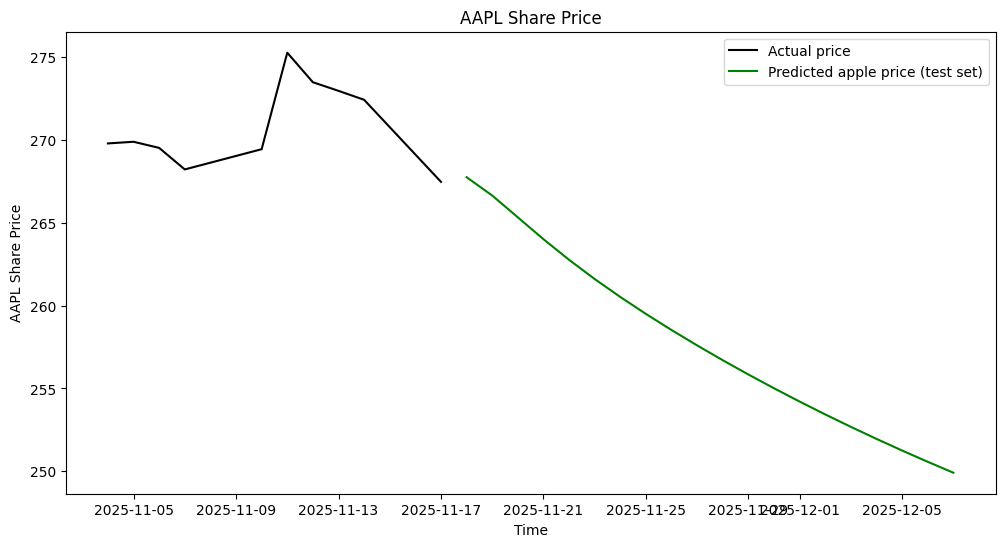

In [ ]:
look_back = 60
plot_back = 10
look_forward = 20
for symbol in symbols_to_check:
    data = read_data_for_symbol(symbol)
    data = data[data['Date'].dt.year == 2025]
    data = data.reset_index(drop=True)
    # data = data[data['Date'].dt.month >= 8]
    print(data.head())
    data, scaler = scale_values_and_make_scaler(data)

    try:
        X_actual, y_actual = get_X_y_for_data(data)
    except Exception as exp:
        print(f"Failed to train data for '{symbol}'")
        continue

    y_pred = model.predict(X_actual)
    y_pred_scaled = scaler.inverse_transform(y_pred)
    y_actual_scaled = scaler.inverse_transform(y_actual.reshape(-1, 1))

    rmse = math.sqrt(mean_squared_error(y_pred_scaled, y_actual_scaled))
    print(f"Root Mean Squared Error for {symbol}", rmse)

    known_dates = data['Date'].to_numpy()[data.shape[0] - plot_back : ]
    known_prices = data['Close'].to_numpy()[data.shape[0] - plot_back : ]
    print(known_dates)
    print(known_prices)

    # Future
    last_sequence = X_actual[-1]

    # Reshape the last_sequence to match the input shape of the model
    last_sequence = last_sequence.reshape(1, look_back, 1)

    # Generate predictions for the next days
    predictions_next_days = []
    for _ in range(look_forward):
        prediction = model.predict(last_sequence)
        predictions_next_days.append(prediction[0, 0])  # Get the predicted value
        last_sequence = np.roll(last_sequence, -1, axis=1)  # Shift the sequence by one day
        last_sequence[0, -1, 0] = prediction  # Update the last element with the new prediction

    predictions_next_days = np.array(predictions_next_days).reshape(-1, 1)

    # Transform the predictions back to the original scale
    predictions_next_days_scaled = scaler.inverse_transform(predictions_next_days).flatten()
    print(predictions_next_days_scaled)

    # Print the predictions for the next 10 days
    print(f"Predictions for the next {look_forward} days:")
    start_date = data.loc[data.shape[0] - 1, 'Date']
    print(start_date)
    future_dates = np.empty((0,), dtype=data['Date'].dtype)
    future_prices = np.empty((0,), dtype=data['Close'].dtype)
    for i, prediction in enumerate(predictions_next_days_scaled, start=1):
        print(f"Day {i}: Predicted Price = {prediction}")
        future_prices = np.append(future_prices, prediction)
        future_dates = np.append(future_dates, start_date + np.timedelta64(i, 'D'))

    plt.figure(figsize=(12, 6))
    plt.plot(known_dates, known_prices, color='black', label="Actual price")
    plt.plot(future_dates, future_prices, color='green', label="Predicted apple price (test set)")

    plt.title(f"{symbol} Share Price")
    plt.xlabel("Time")
    plt.ylabel(f"{symbol} Share Price")
    plt.legend()
    plt.show()
